# Lab3.4 Training an emotion classifier with a bag-of-words

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

The goal of this notebook is to show how you can create a classifier that can detect emotions in conversations using the scikit-learn package. 
The notebook will give you a recipe to train a classifier to assign sentiment labels to texts and evaluate their performance. This counts as supervised learning because the labels are assigned by people judging the texts and the machine mimics this behaviour.

**At the end of this notebook, you will be able to**:
* load data from a CSV file on disk, i.e. conversations from the Friends sitcom annotated with emotion labels
* represent the texts as a Bag-of-Words
* convert Bag-of-Word counts to TF-IDF values
* train an *SVM* (Support Vector Machine) with the training data set
* save the model to disk
* load and use the model to apply to other data

### Table of Contents
* [Section 1: The data: utterances and emotions](#section1)
* [Section 2: Using Pandas to load data](#section2)
* [Section 3: Representing the text as numerical Bag-of-Words vectors](#section3)
* [Section 4: Training a Suppert Vector Machine classifier](#section4)
* [Section 5: Saving and reusing a classifier](#section5)
* [Section 6: The Magic Recipe for building a text classifier](#section6)

## 1. The data: utterances and emotions  <a class="anchor" id ="section1"></a> 

For training and testing, we are going to use data from the MELD project. MELD stands for Multimodal Emotion Lines Dataset, which is a data set with 13,000 utterances from 1,433 dialogues of the TV-series Friends. Each utterance is annotated with emotion and sentiment labels, and encompasses audio, visual, and textual modalities. The data set is available at:  http:// affective-meld.github.io but the text part of the data has been included here in the data folder. The following paper describes the data set in detail:

    S. Poria, D. Hazarika, N. Majumder, G. Naik, E. Cambria, R. Mihalcea. MELD: A Multimodal Multi-Party Dataset for Emotion Recognition in Conversation. ACL 2019: https://arxiv.org/pdf/1810.02508.pdf

The data are labeled with the six basic emotions that Ekman and his team claimed to hold universally across the facial expressions of people from many different cultures:

Ekman, Paul, Wallace V. Friesen, Maureen O'sullivan, Anthony Chan, Irene Diacoyanni-Tarlatzis, Karl Heider, Rainer Krause et al. "Universals and cultural differences in the judgments of facial expressions of emotion." Journal of personality and social psychology 53, no. 4 (1987): 712

<img src="images/ekman-faces.png" width="500" height="600">

The emotions are: anger, disgust, fear, joy, sadness and surprise.

The data is taken from the [MELD](https://github.com/declare-lab/MELD) Github repository. The MELD project created this data for multimodal emotion detection in conversations using facial, audio and textual signals. Here we are only going to use the textual data. For convenience, the textual data are also provided in this Lab in the ```data/MELD``` folder, where you find three CSV files (Comma Separated Values):

* dev_sent_emo.csv
* test_sent_emo.csv
* train_sent_emo.csv

CSV stands form Comma Separated Values. This is a text format for tables, also an export format of Excel. CSV is often used to store data. The data on the original Github has some issues with non-Unicode characters that we has to remove. Therefore we advise that you use the local CSV files that are provided.

You can open the CSV files in this notebook by double cliking on each. The file 'train_sent_emo.csv' will open in a new TAB which looks as follows:

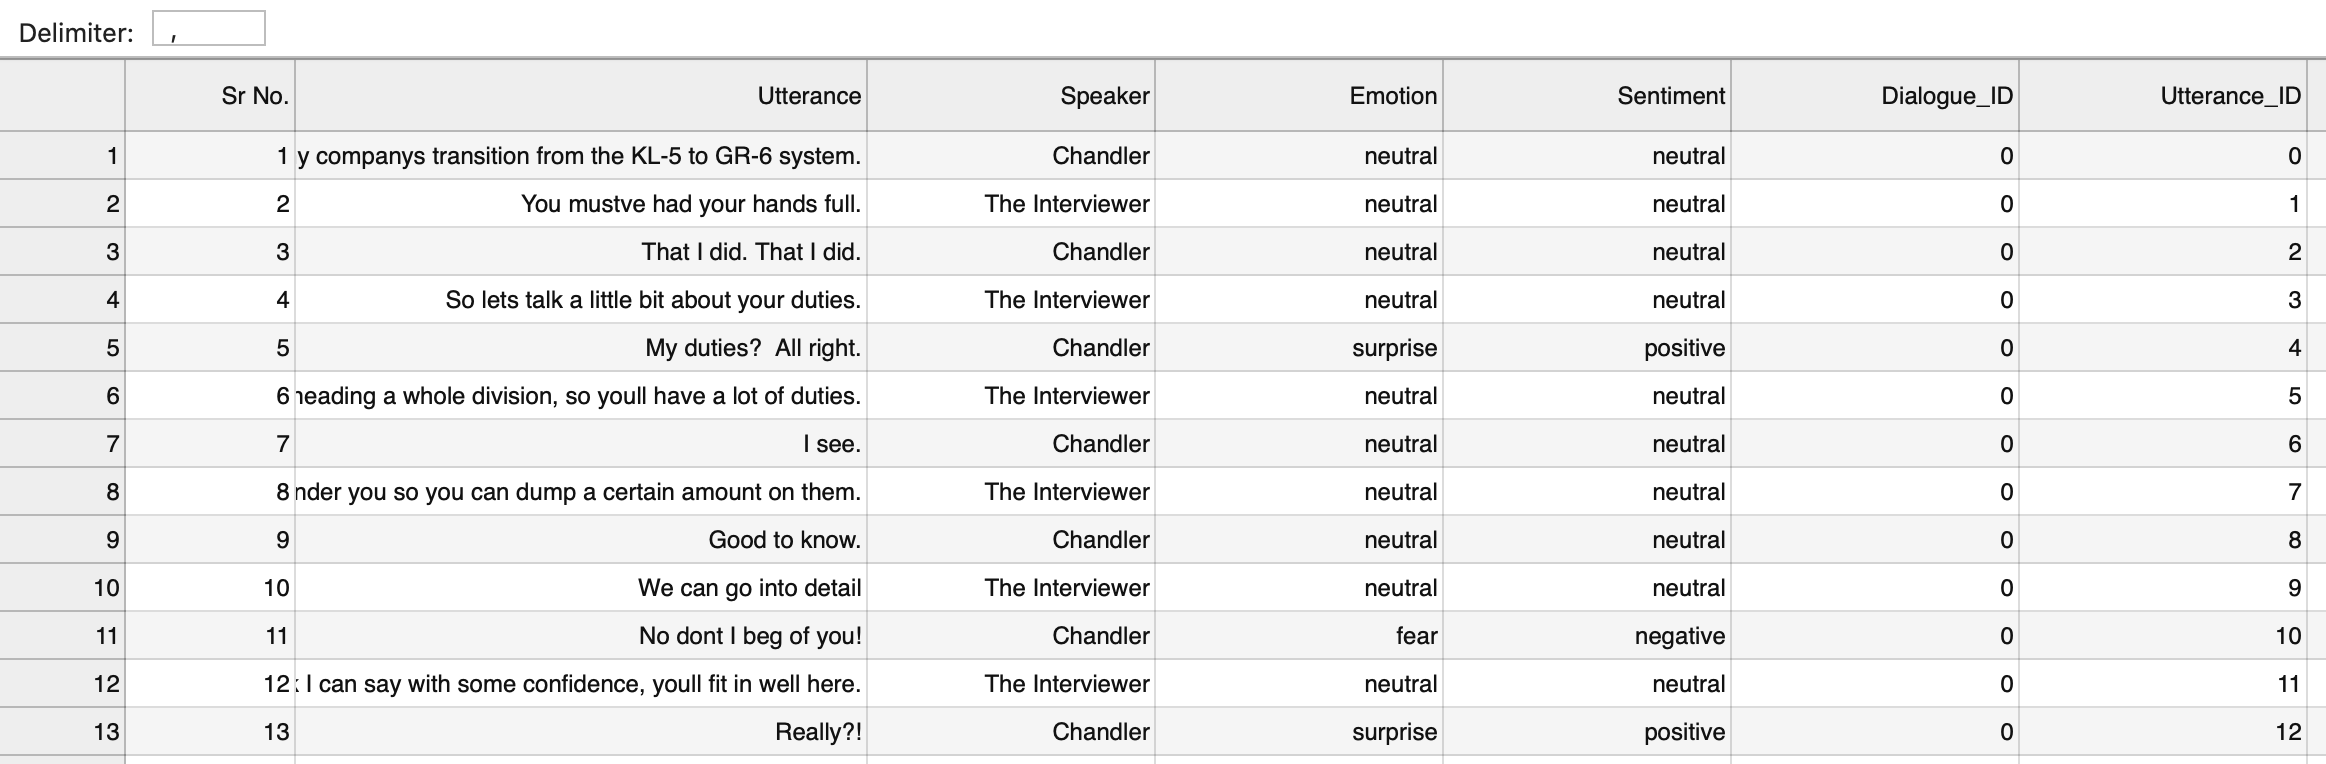

The first line shows the header. You see that the rows and columns are indeed separated by the delimiter ",". You can scroll through the table as in a file editor or spread sheet. CSV files can also be opened in other programs such as Excel and you can save excel files to CSV.

Opening a CSV. file in a notebook is a nice way to quickly get an idea about the content. We can see that there is a column with the utterances and columns for the emotion and the sentiment as annotations. We will use the utterances and emotion columns for training a classifier to detect the emotion in any utterance. There are other columns as well, but we will ignore these in this notebook.

In the next section, we will introduce you to the Pandas package for loading and accessing such data. Pandas is a popular Python package for data.

## 2. Using Pandas to load data <a class="anchor" id ="section2"></a> 

Instead of opening the data file in another TAB in Jupyter notebook, we want to read the data from the file in *memory* in the current notebook and feed it to the learning machine. We could write Python code to read the CSV file line by line and parse the columns to get the data. However, there is a powerful package for loading data called `Pandas`  https://pandas.pydata.org, which we are going to use instead.

Note that Pandas can be tricky when loading your own data. Be aware of that. Eventually, you may want to follow a tutorial on the web on how to use Pandas but for now you can simply follow the instructions below.

Pandas needs to be installed separately on your local machine first. The package should already have been installed through the ```requirements.txt```.

If that is not the case, please install pandas locally from the command line, using either of the two following instructions:

* >`conda install pandas==2.2.3`
* >`python -m pip pandas==2.2.3`

If the installation was succesful, you can now import 'pandas' in this notebook. If Jupyter notebook does not know 'pandas', try restarting the kernel or even restarting Jupyter.

In [1]:
import pandas as pd

If there is no error, you imported pandas and created the instantiation 'pd'. We can now use 'pandas' functions and data elements through the variable 'pd'.

Our input file is located in the 'data/MELD' folder within this lab folder. We could set the path to the training file directly using the relative path:

```
#Path to the training data
filepath = './data/MELD/train_sent_emo.csv'
```

However, there can be issues if you are running the notebook somewhere else, so make sure that ```data``` folder is next to this notebook.
We define the path to this file relative to this notebook. 

In [2]:
filepath = 'data/MELD/train_sent_emo.csv'

Next, we use the 'pd.read_csv' function to read the data from the file. This function returns a so-called **Dataframe** object, which is the object that holds all the data in memory for further processing. We are going to assign this object as a value to the variable `dftrain`.

In [3]:
# Create a dataframe object 'dftrain' by readig the file.
dftrain = pd.read_csv(filepath)

There are no error messages when reading the csv so the dataframe ```dftrain``` was succesfully created.

There are two useful functions to inspect data in a dataframe. The 'dftrain.info()' function gives us a technical overview of all the data, showing the column names and order, the number of cells with values per column (non-null) and the data type per column.

In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


There are 9,989 indexed rows (entries) in our data frame and all cells have values (non-null). We also see the list of column headers and their data type.

We can now use 'dftrain.head()' function to show the content for the ''head'' of the table. You can pass in a number for the range of rows you want to see. Here we look at the first ten.

In [5]:
dftrain.head(10)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company's tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must've had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let's talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
5,6,"Now you'll be heading a whole division, so you...",The Interviewer,neutral,neutral,0,5,8,21,"00:16:41,126","00:16:44,337"
6,7,I see.,Chandler,neutral,neutral,0,6,8,21,"00:16:48,800","00:16:51,886"
7,8,But there'll be perhaps 30 people under you so...,The Interviewer,neutral,neutral,0,7,8,21,"00:16:48,800","00:16:54,514"
8,9,Good to know.,Chandler,neutral,neutral,0,8,8,21,"00:16:59,477","00:17:00,478"
9,10,We can go into detail,The Interviewer,neutral,neutral,0,9,8,21,"00:17:00,478","00:17:02,719"


In a similar way, we can also inspect the tail.

In [6]:
dftrain.tail(10)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
9979,10469,How many perfectly fine women are you gonna re...,Monica,surprise,negative,1038,8,2,3,"00:00:28,319","00:00:32,573"
9980,10470,"Hold it, hold it.",Joey,neutral,neutral,1038,9,2,3,"0:00:32,824","0:00:33,456"
9981,10471,I gotta side with Chandler on this one.,Joey,neutral,neutral,1038,10,2,3,"0:00:33,456","0:00:35,556"
9982,10472,"When I first moved to the city, I went out a c...",Joey,disgust,negative,1038,11,2,3,"00:00:35,744","00:00:44,334"
9983,10473,It made me nuts.,Joey,disgust,negative,1038,12,2,3,"00:00:45,462","00:00:46,587"
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"
9988,10478,"That was a good one. For a second there, I was...",Joey,joy,positive,1038,17,2,3,"00:01:08,401","00:01:12,071"


## 3. Representing the texts as Bag-of-Words <a class="anchor" id ="section3"></a> 

For training a machine learning system you need a number of packages, the most important ones are *sklearn* and *numpy* to manipulate data and call machine learning functions. Since we are dealing with texts, we also need some specific packages from *sklearn* to operate on texts to get words as features. Finally, we use the *nltk* package to split a text in words and to get a list of *stop words*. *Stop words* occur frequently and are not very discriminative across texts. We assume you have all these packages already installed throught the ```requirements.txt``` so you can import them here.

In [7]:
import sklearn
import numpy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

To get the training texts and the corresponding labels, we can simple assign the complete Pandas columns `Utterances` and `Emotion` to two variables.

In [8]:
training_instances=dftrain['Utterance']
training_labels=dftrain['Emotion']
print(len(training_instances))
print(len(training_labels))

9989
9989


Obviously, the lists of texts and labels should be of the same length and in the same order.

The text and the label for the 11th utterance: *training_instances[10]* can now be retrieved from the list of labels:

In [9]:
print('Utterance:', training_instances[10], 'Emotion label:', training_labels[10])

Utterance: No don't I beg of you! Emotion label: fear


## Machines don't like words, they prefer numbers!

We are going to use the **CountVectorizer** function to create a **Bag-of-Words** presentation for the utterances as we have done in the previous notebook 3.1 for the toy data. We define an instance of CountVectorizer for the data set and set a number of parameters that define the model:

* `min_df`: a frequency threshold below which words are ignored to represent a document
* `max_df`: a frequency threshold above which words are ignored to represent a document
* `tokenizer`: a tokenizer that determines what the words are in a text (a.o. separating punctuation from words)
* `stop_words`: an explicit list of words to be excluded from the representation

These parameter settings can be adapted to create a different model. Increasing the `min_df` threshold and lowering the `max_df` threshold mean less words to represent a document. In general, words that only occur **once** generalise poorly to other data and words that occur **frequently** across texts discriminate poorly between different texts. Furthermore, stop word lists are often derived from large text collections taking the most frequent words. Removing these may boil down to setting a `max_df` threshold. However, this is not always the case and you could add specific words yourself to remove noisy or disturbing words from the model.

As a language technology engineer, you need to think about these parameter settings in relation to properties of the texts and the interpretation labels. These are considerations that may be relevant:

* Which words are excluded by setting thresholds or using stopwords and how relevant are these for the interpretation labels?
* Which words occur a lot and do not convey information for my labels?

By experimenting with the parameters, you may tune a model to your texts and your interpretations. For example, words such as "not", "should", could be very relevant for emotion detection.

Below, we set the minimal frequency to '5', so we ignore words occurring less frequently. We als ignore stopwords as defined by the NLTK library. Finally, we use NLTK to split the text into a list of tokens.

To get an idea what these parameters do, you can experiment with the values and check the effect. This is different for each data set.

In [13]:
# Turn utterances train data into a vector 
frequency_threshold = 5
utterance_vec =CountVectorizer(min_df=frequency_threshold, # If a token appears fewer times than this, across all documents, it will be ignored
                             tokenizer=nltk.word_tokenize, token_pattern=None, # we use the nltk tokenizer
                             stop_words=stopwords.words('english')) # stopwords are removed


Do you always want to remove stopwords? Perhaps not. Stopwords are very frequent words in a language, such as "I", "you", "not". They have little content but they could be very important for understanding the emotion expressed in a text. Check the stopwords to see if removing these is useful.

In [14]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Following your intuition, you can decide to not use stopwords (remove the parameter from the function call) or to adapt the stopword list. You can build different classifiers with different settings and see if their performance differs.


We now created a specific instance `utterance_vec` of the **CountVectorizer** with the parameter settings. We can use **utterance_vec** to generate a vector representation from our texts and count how often which words ocurred in each text. 

**To recap:**
The vector representation reserves positions in the list for each word in the complete data set that matches the parameter conditions. If there are only 5 words, it is a vector of five positions. When initialised it will contain five zeros: `[0,0,0,0,0]`. Each document is then represented by counting how frequent each of these words occurs in the text, replacing the zeros by the counts if these words are present. If words do not occur the counts remain zero.

In order to represent each document in terms of such a vector derived from the complete data set, we use the ```fit_transform``` function to generate a matrix of documents (rows) and  vector representations for each document. The function counts how frequently each word occurs in each document and updates the corresponding positions in each vector (row). This creates the **Bag-of-Words** (BoW) representation of the document.

Now that we created an instance of the CountVectorizer *utterance_vec* with the defined settings, we can use the CountVectorizer functions of this instance to create vector representations from our training data. The function *fit_transform* function will do two things:

<ol>
<li> it will create a dictionary with all unique tokenized words that fit the settings and generate a vector with the length equal to the number of words, such that each position corresponds with one of these words
<li> it will transform each utterance into a bag-of-words vector representation by counting how frequent each word occurs in the utterance
</ol>

Note: you might get a warning when you run the following cell. You do NOT have to resolve the warning. It is just a suggestion to extend the stop words list.

In [16]:
training_count_vectors = utterance_vec.fit_transform(training_instances)

We have now created a vector representation *training_count_vectors* of the vocabulary of the full data set for words occurring 5 times or more. Every position in this vector represents a unique word token.

The length of the *vocabulary_* property indicates the length of the lexicon and therefore the length of the vectors or the number of feature dimensions.

In [17]:
#Total number of word features or the length of the total vector
print('Total number of words in our vectors, which represent dimensions in the model:', len(utterance_vec.vocabulary_))

Total number of words in our vectors, which represent dimensions in the model: 1103


We can get the *names* of the positions in the vector using the function *get_feature_names*. Below we show the first 50 names.

In [18]:
# First 50 feature names
print(list(utterance_vec.get_feature_names_out())[:50])

['!', '$', "'", "''", "'cause", "'d", "'em", "'kay", "'ll", "'m", "'re", "'s", "'ve", '(', ',', '--', '.', '..', '...', '....', '.....', '10', '2', '25', '30', '40', '7', '8', ':', ';', '?', '``', 'able', 'absolutely', 'accident', 'across', 'actor', 'actual', 'actually', 'age', 'ago', 'ah', 'ahh', 'air', 'alan', 'almost', 'alone', 'along', 'already', 'alright']


Our data is a list of vectors which represents a matrix with the text vectors on each row. Using *shape*, we can get the dimensions of the matrix:

In [19]:
print(training_count_vectors.shape)

(9989, 1103)


In [20]:
# this vector is small enough to view in full! 
print('The vocabulary of all the sentences consists of the following words:', 
      len(list(utterance_vec.vocabulary_.keys())))
print('These words are mapped to the data columns as feature names:', 
      len(utterance_vec.get_feature_names_out()))

The vocabulary of all the sentences consists of the following words: 1103
These words are mapped to the data columns as feature names: 1103


This means we have a list of *9,989* vectors, each with the length of the size of the vocabulary, if the threshold is set to frequency 5 and you remove stopwords it will be *1103* positions. If you did NOT remove the stopwords this is *1217* positions for words. If you change the frequency threshold the number of columns changes again.

We can inspect the vector for each utterance in the training data. So here are the first 50 counts for item=5 out of the 9,989 vectors. Note that we need to convert the matrix to an arrray to be able to print it.

In [21]:
item = 5
print(training_count_vectors.toarray()[item][:50]) ### showing the values for the first 50 dimensions of the first utterance

[0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see that most values are zeros and few have a count. This is what we call a *sparse vector*. If you change the parameter settings when defining **utterance_vec** to use more words, the vector becomes larger and more words of a text are represented. The question is whether these words are also useful, e.g. sufficiently shared across different documents.

As we have seen in the previous notebooks, we can also transform the counts into information value scores using the *TfidfTransformer* function.

In [22]:
# Convert raw frequency counts into TF-IDF values
tfidf_transformer = TfidfTransformer()

#### For training data we use fit_transform
training_tfidf_vectors = tfidf_transformer.fit_transform(training_count_vectors)

The shape remains the same but the values are now scores between zero and one that indicate the information value of each word given the dispersion over all the data.

In [23]:
# Same dimensions, now with tf-idf values instead of raw frequency counts
print(training_tfidf_vectors.shape)
print(training_tfidf_vectors.toarray()[item][:50]) ### showing the values for the first 50 dimensions

(9989, 1103)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.71080374 0.         0.         0.
 0.         0.         0.13354424 0.         0.12221367 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


We see that the non-zero values are now differentiated into real numbers or floats that represent not only presence but also the information value of the word.

Think about these values for this data set. The texts are short and there may not be a topical distribution for these utterances. Is *TF.IDF* really useful for this data set and for capturing emotions?

## 4 Training and using the classifier <a class="anchor" id ="section4"></a> 

We can now use the above text representations as training data to build a classifier. In this note book we are going to use a so-called **Support Vector Machine** or **SVM**. This is a more advanced classifier that belongs to the family of discriminative models. This means it learns a weight for each feature (in our case words) to predict the right class (in our case an emotion). SVMs typically try to find the right separation between negative and positive examples for the feauture words by adjusting the weights: all wrong ones on one side and right ones on the other side. You can check out another tutorial for more information: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In NLP, SVM classifiers have shown to perform very well for many tasks if you have a substantial amount of data. There are many more classifiers in **sklearn** and you will learn more about these in the Machine Learning for NLP course.

We import svm from sklearn and select a **LinearSVC** type, which is a standard model. We also set a maximum to the number of iterations it should make over the training data when trying to learn sufficiently discriminative features. We use the **fit** funcion to pass in the training data and the corresponding list of labels.

In [24]:
from sklearn import svm
svm_linear_clf = svm.LinearSVC(max_iter=2000)
svm_linear_clf.fit(training_tfidf_vectors, training_labels)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


We now trained the classifier ```svm_linear_clf``` with the training data and we can use it to predict an emotion on any other text. So here are some text examples:

In [25]:
# some utterances
some_chat = ['That is sweet of you', 
               'You are so funny', 
               'Are you a man or a woman?', 
               'Chatbots make me sad and feel lonely.', 
               'Your are stupid and boring.', 
               'Two thumbs up', 
               'I fell asleep halfway through this conversation', 
               'Wow, I am really amazed.', 
               'You are amazing I think.',
             'I feel so low and sick being in isolation',
             'People dumping waste are horrible',
             'Its awful that you cannot stop smoking like I did.',
             'Dogs scare me and I hate them',
             'I am afraid I, I, I, I will will get sick sick sick at work',
             'I run away when I see a dog',
             'When do you start your job?'
            ]

some_chat_gold = ['joy', 'joy', 'neutral', 'sadness', 'anger', 'joy', 'anger', 'surprise', 'joy', 'sadness', 'disgust', 'disgust', 'fear', 'fear', 'fear', 'neutral']

print(len(some_chat), len(some_chat_gold))

16 16


To be able to apply our model to these texts, we need to represent the text using the same vector dimensions (columns!) as we used for training the model.

The sklearn transformer function does this work for you using the ```transform``` function. This function uses the vector model from the training data. Note that these vectors only have a position for every word from the training data but not for words that never occur in the training data (or fall outside your frequency thresholds). So we cannot represent words that do not occur outside the training data, so-called Out-of-Vocabulary (OoV) words. Technically, we do not need to worry because the **transform** function will take care of this but you can imagine that texts that are very different from the training data will be represented poorly by the model.

In [26]:
### We first count words in each chat that occur also in the trainign data
some_chat_vec = utterance_vec.transform(some_chat)
### We take these counts and transform them in information value scores using TD*IDF
some_chat_tfidf = tfidf_transformer.transform(some_chat_vec)

To check the representation, we can ask for the shape of the matrix to see if we have the correct number of dimensions.

In [27]:
some_chat_tfidf.shape

(16, 1103)

We see that we have 16 texts, each represented with a vector with 1103 dimensions, which is exactly the vector model derived for the training data. We can again inspect each item from our 16 texts:

In [28]:
print(some_chat_tfidf.toarray()[6][:100]) ### showing the values for the first 100 dimensions

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.55452595 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


We can see here that there is only one dimension with a value in the first 100 dimensions of the vector of this utterance. 

WARNING! Using the **fit_transform** function instead of **transform** for our some_chat data, would create a whole new model from our 16 turns and repersent the text in a way that is incompatable with our training model. In fact it will change our **utterance_vec** based on the words from the some_chat data. So if you run the next cell, you need to rebuild the **count_vec**.

In [81]:
#### NEVER DO THE FOLLOWING ON OTHER DATA THAN TRAINING DATA
#bad_some_chat_counts = utterance_vec.fit_transform(some_chat)
#bad_some_chat_counts.shape

#Running this will give a shape of 
#(16,1) 
#and make count_vec useless

Depending on the parameter settings of your ```utterance_vec```, you will get either no or only a few dimensions because the CountVectorizer created complete new vector representations using our settings: min_df=5,tokenizer=nltk.word_tokenize, stop_words=stopwords.words('english'). The vector only represents words from same_chat and this representation is incompatible with our trained model. So we cannot use this representation!!

This is a mistake you are likely to make. Remember:

1. build a vectore representation from the features from the training data: use **fit** or **fit_transform** with your defined CountVectorizer instance
2. train a classifier from these representation using the **fit** function
3. always, always(!) use the **transform** function from your defined CountVectorizer instance (which has been derived using the training data) to represent other texts that you want to classify

It is good practice to always use the **shape** function to check that the data has the same number of dimensions as the training data.

So lets return to the proper representation and see what predictions are made by our trained mode.

In [30]:
some_chat_pred = svm_linear_clf.predict(some_chat_tfidf)
for review, predicted_label, gold_label in zip(some_chat, some_chat_pred, some_chat_gold):
    print('%s =>  gold: %s predicted: %s, ' % (review, gold_label, predicted_label))

That is sweet of you =>  gold: joy predicted: joy, 
You are so funny =>  gold: joy predicted: neutral, 
Are you a man or a woman? =>  gold: neutral predicted: neutral, 
Chatbots make me sad and feel lonely. =>  gold: sadness predicted: sadness, 
Your are stupid and boring. =>  gold: anger predicted: anger, 
Two thumbs up =>  gold: joy predicted: neutral, 
I fell asleep halfway through this conversation =>  gold: anger predicted: neutral, 
Wow, I am really amazed. =>  gold: surprise predicted: surprise, 
You are amazing I think. =>  gold: joy predicted: joy, 
I feel so low and sick being in isolation =>  gold: sadness predicted: neutral, 
People dumping waste are horrible =>  gold: disgust predicted: neutral, 
Its awful that you cannot stop smoking like I did. =>  gold: disgust predicted: neutral, 
Dogs scare me and I hate them =>  gold: fear predicted: disgust, 
I am afraid I, I, I, I will will get sick sick sick at work =>  gold: fear predicted: neutral, 
I run away when I see a dog =

### 5. Saving and reusing your classifier another time <a class="anchor" id ="section5"></a> 

When we are happy about our classifier, we may want to save it so that we can use it in another notebook or program. Python provides a package called *pickle* with which you can save what is in memory (our model) to a file on disk as so-called binary data. You can then load this file at a later point to use it in your code. 

Let's see how that works for our classifier by saving it in the subfolder "models". Remember you need to have a folder in this lab called models. If not, create it first before running the next code.

We will save three things:

* the vectorizer so that we can represent other texts using the vector model
* the tfidf transformer so we can convert the counts in our text to TFIDF values
* the actual sklearn classifier that we created


In [32]:
import pickle

# save the countvectorizer
filename_vectorizer = './models/utterance_vectorizer.sav'
pickle.dump(utterance_vec, open(filename_vectorizer, 'wb'))

# save the tfidf transformer
filename_tfidftransformer = './models/utterance_tfidf_transformer.sav'
pickle.dump(tfidf_transformer, open(filename_tfidftransformer, 'wb'))

# save the classifier to disk
filename_classifier = './models/svm_linear_clf_bow.sav'
pickle.dump(svm_linear_clf, open(filename_classifier, 'wb'))

Now check your *models* folder to see the four data files that you saved. You could now save and stop this notebook and use these classifiers some other time. We next show how to load them again to classify some text.

In [33]:
# some time later...

# load the classifier and the vectorizer from disk
loaded_classifier = pickle.load(open(filename_classifier, 'rb'))
loaded_vectorizer = pickle.load(open(filename_vectorizer, 'rb'))
loaded_tfidftransformer = pickle.load(open(filename_tfidftransformer, 'rb'))

We now use the loaded versions to represent and classify the next chats.

In [34]:
# some utterances
another_chat = ['This is a boring day for me. I hate it', 
               'You are not funny and I do not like your family, actually disgust them'
            ]
another_chat_gold = ['sadness', 'disgust']

print(len(another_chat), len(another_chat_gold))

2 2


In [35]:
new_counts = loaded_vectorizer.transform(another_chat)
another_chat_tfidf = loaded_tfidftransformer.transform(new_counts)
another_chat_tfidf.shape

/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


(2, 1103)

In [36]:
print(another_chat_tfidf.toarray()[1][300:400]) ### showing the values for dimensions between 300 and 400

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.59813326 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.53291065
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


We see that the loaded vectorizer and tfidf transformer, created vector representations that are compatible with our trained model with 1103 dimensions. We can now use the loaded classifier to get prediction on these texts.

In [37]:
another_chat_pred = loaded_classifier.predict(another_chat_tfidf)
for turn, predicted_label, gold_label in zip(another_chat, another_chat_pred, another_chat_gold):
    print('%s => predicted: %s, gold: %s' % (turn, predicted_label, gold_label))

This is a boring day for me. I hate it => predicted: neutral, gold: sadness
You are not funny and I do not like your family, actually disgust them => predicted: neutral, gold: disgust


These results are not very good. We refer to the next Lab4, to properly test and evaluate our classifier.

### 6. The Magic Recipe for Training a Text Classifier <a class="anchor" id ="section6"></a> 

To build a text classifier, we proceed in seven steps:

<ol>
    <li>We load the texts and their labels</li>
    <li>We create a CountVectorizer instance with certain parameter settings 
    <li>We use the <b>fit_transform</b> function of the vectorizer to:
        <ol>
            <li>create vector dimension for each word from the dataset that fits the parameter settings
            <li>represent each text as a vector with words counts for each dimension
        </ol>
    <li>We transfer the count values using <b>TfidfTransformer</b> to information value scores
    <li>We create an <b>SVM</b> classifier from the vector representations of the training data and their corresponding labels
    <li>We represent some other text in the same dimensions using the vectorizer and tfidf transformer of the training data</li>
    <li>We apply the classifier to the vector representation of the new text to get the predictions
</ol>

You can use the above zeven steps as a **magic recipe** to create and test any type of text classifier.

# End of this notebook